In [ ]:
import os, sys

recsys_cf = os.environ.get("RECSYS_STORY")
sys.path.append(recsys_cf)
os.chdir(recsys_cf)

from lib.tools import *

In [ ]:
from pyspark.sql.types import *

In [ ]:
import loader as load

# spark 

In [4]:
SPARK_CONFIG["process_label"] = "story_popular_model"
SPARK_CONFIG["numofcores"] = 15

In [6]:
sp = spark(**SPARK_CONFIG)
hive = sp.sql

# Load_data 

In [9]:
%%time
ratings = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_RATINGS, hive).cache()

CPU times: user 3.69 ms, sys: 472 µs, total: 4.17 ms
Wall time: 209 ms


In [10]:
ratings.show()

,user_id,item_id,timestamp,rating,prediction
0,471,291958095,None,0.0,0.000010
1,496,291958095,None,0.0,0.000003
2,1088,291958095,None,0.0,-0.000001
3,1238,291958095,None,0.0,0.000001
4,1342,291958095,None,0.0,0.000005
5,1580,291958095,None,0.0,-0.000010
6,1591,291958095,None,0.0,0.000004
7,1829,291958095,None,0.0,0.000007
8,2122,291958095,None,0.0,0.000018
9,2142,291958095,None,0.0,-0.000002


# load_data 

###### clickstream_for_popular_model 

In [14]:
start_d = '2021-12-01'
end_d = '2022-01-01'

sql_query_ctl = """
SELECT DISTINCT ctl_loading
FROM {scheme}.{ctl_table}
WHERE 1=1
  AND (min_sessiondate >= '{start_date}'
       OR max_sessiondate >= '{start_date}')
  AND (min_sessiondate < '{end_date}'
       OR max_sessiondate < '{end_date}')
""".format(scheme=SBX_TEAM_DIGITCAMP,
           ctl_table=GA_VISIT_CTL_DATE_MAP,
           start_date=start_d,
           end_date=end_d)

ctl_loading_list = hive.sql(sql_query_ctl).toPandas()["ctl_loading"]

min_ctl = ctl_loading_list.min()
max_ctl = ctl_loading_list.max()

In [16]:
visit_query = """
SELECT sbbolUserId,
       sessionDate,
       sessionStartTime,
       visitNumber,
       hitTime,
       hitNumber,
       hitPagePath,
       hitType,
       eventCategory,
       eventAction,
       eventLabel
FROM {visit_scheme}.{visit_tb_name}
WHERE 1=1
  AND ctl_loading >= {min_ctl_loading}
  AND ctl_loading < {max_ctl_loading}
  AND sessiondate >= '{start_date}' 
  AND sessiondate < '{end_date}'
  AND hitPageHostName like 'sbi.sberbank.ru'
""".format(visit_scheme="prx_google_analytics_part_external_google_analytics",
           visit_tb_name="visit",
           start_date=start_d,
           end_date=end_d,
           min_ctl_loading=min_ctl,
           max_ctl_loading=max_ctl)

In [17]:
sbbol_clickstream = hive.sql(visit_query).cache()

# create_popular_model 

###### add_product 

In [18]:
pattern1 = 'product\: [^]]*]{1}'
pattern2 = 'product\: [^,]*,{1}'
clickstream_product = sbbol_clickstream.withColumn('product',f.regexp_extract("eventLabel", pattern1, 0))\
                                      .withColumn('product',
                                                  f.when(f.col("product").like("%,%"),
                                                  f.regexp_extract("eventLabel", pattern2, 0))\
                                      .otherwise(f.col("product")))
clickstream_product = clickstream_product.withColumn("product",
                                                     f.col("product").substr(f.lit(10), f.length("product") - 10))

###### story_show 

In [19]:
sbbol_story_show = clickstream_product.filter("eventCategory like '%[operations]: offers%'")\
                                      .filter("eventAction like '%impression-story%'")\
                                      .filter("eventLabel like '%[placement: main[main_feed]]%'")

In [20]:
%%time
sbbol_story_show.cache()
sbbol_story_show.count()

CPU times: user 73.2 ms, sys: 38.9 ms, total: 112 ms
Wall time: 6min 15s


In [21]:
story_show_cnt = sbbol_story_show.groupBy("product").agg(f.count("sbbolUserId").alias("story_show_cnt"),
                                                         f.countDistinct("sbbolUserId").alias("story_show_dist_cnt"))\
                                 .orderBy(f.col("story_show_cnt").desc()).cache()

In [22]:
story_show_cnt.count()

67

In [23]:
story_show_cnt.show()

,product,story_show_cnt,story_show_dist_cnt
0,none,42005161,1135507
1,korpkarta,6410243,983753
2,merchant-acquiring,3177547,723396
3,credit_card,2738191,628572
4,e_inv,2247938,718187
5,kredit,2126215,550974
6,zarplata,2102960,550790
7,lyurist,1968371,598011
8,mybuch,1842126,534747
9,mybuch_online_sso,1675561,488732


###### story_clicks 

In [24]:
sbbol_story_click = clickstream_product.filter("eventCategory like '%[operations]: offers%'")\
                                       .filter("eventAction like 'open card'")\
                                       .filter("eventLabel like '%[placement: main[main_feed]]%'").cache()

In [25]:
story_click_cnt = sbbol_story_click.groupBy("product").agg(f.count("sbbolUserId").alias("story_click_cnt"),
                                                           f.countDistinct("sbbolUserId").alias("story_click_dist_cnt"))\
                                   .orderBy(f.col("story_click_cnt").desc()).cache()

In [26]:
%%time
story_click_cnt.count()

CPU times: user 8.9 ms, sys: 4.88 ms, total: 13.8 ms
Wall time: 34.4 s


58

In [27]:
story_click_cnt.show()

,product,story_click_cnt,story_click_dist_cnt
0,none,91308,59570
1,korpkarta,8642,7090
2,kredit,4988,4042
3,credit_card,4922,4248
4,merchant-acquiring,4891,4175
5,zarplata,1911,1580
6,e_inv,1864,1597
7,mybuch_online_sso,1481,1237
8,e-acquiring,1180,1006
9,smart_credit,944,782


###### result 

In [28]:
story_show_stats = story_show_cnt.join(story_click_cnt,
                                       on='product',
                                       how='left')\
                                 .withColumn("story_click_dist_cnt",
                                              f.when(f.col("story_click_dist_cnt").isNull(), 0)\
                                               .otherwise(f.col("story_click_dist_cnt")))\
                                 .withColumn("story_click_cnt",
                                             f.when(f.col("story_click_cnt").isNull(), 0)\
                                              .otherwise(f.col("story_click_cnt")))\
                                 .withColumn("perc",
                                             f.col("story_click_dist_cnt") / f.col("story_show_dist_cnt"))\
                                 .orderBy(f.col("perc").desc())

In [29]:
story_show_stats.count()

67

In [30]:
story_show_stats.show(63)

,product,story_show_cnt,story_show_dist_cnt,story_click_cnt,story_click_dist_cnt,perc
0,pos-partner-cabinet,6,4,1,1,0.250000
1,brokerage,9,5,1,1,0.200000
2,spfl,54,25,5,4,0.160000
3,none,42005161,1135507,91308,59570,0.052461
4,sberanalytics,377,67,4,2,0.029851
5,smart_credit,199336,29946,944,782,0.026114
6,bip,96809,35565,568,443,0.012456
7,guarantee,113205,20770,218,197,0.009485
8,sberrating,29245,12014,114,105,0.008740
9,kredit,2126215,550974,4988,4042,0.007336


# popular model 

In [31]:
now_time = datetime.fromtimestamp(time.time())

popular_model_ratings = story_show_stats.filter("story_show_cnt > 10000")\
                                        .filter("product <> 'none'")\
                                        .select(f.col("product").alias("prod_cd_asup"),
                                                f.col("perc").alias("ratings"))\
                                        .withColumn('load_dt', f.lit(f.current_date().cast(StringType())))

In [32]:
popular_model_ratings.show(63)

,prod_cd_asup,ratings,load_dt
0,smart_credit,0.026114,2022-01-14
1,bip,0.012456,2022-01-14
2,guarantee,0.009485,2022-01-14
3,sberrating,0.008740,2022-01-14
4,kredit,0.007336,2022-01-14
5,korpkarta,0.007207,2022-01-14
6,c7m,0.007054,2022-01-14
7,credit_card,0.006758,2022-01-14
8,merchant-acquiring,0.005771,2022-01-14
9,loyalty_business,0.004916,2022-01-14


# save_popular_model

In [33]:
drop_table(SBX_TEAM_DIGITCAMP, "RECSYS_STORY_POPULAR_MODEL", hive)

In [34]:
create_table_from_df(SBX_TEAM_DIGITCAMP, "RECSYS_STORY_POPULAR_MODEL", popular_model_ratings, hive)

In [35]:
load_table(SBX_TEAM_DIGITCAMP, "RECSYS_STORY_POPULAR_MODEL", hive).count()

49

# load_users_from_iskra 

In [36]:
import loader as load

In [37]:
ld = load.Loader(init_dsn=True, encoding='cp1251',  sep=',')
db = load.OracleDB('tech_iskra[iskra]', 'Uthvfy123', ld._get_dsn('iskra4'))
db.connect()

In [38]:
ISKRA_TABLE = "ma_cmdm_ma_customer_sbbol"

In [40]:
query = '''
SELECT * 
FROM {}
'''.format(ISKRA_TABLE)

In [39]:
db = OracleDB('iskra4')

In [40]:
sbbol_customer = hive.read.format('jdbc')\
                          .option('url', 'jdbc:oracle:thin:@//' + db.dsn) \
                          .option('user', db.user) \
                          .option('password', db.password) \
                          .option('dbtable', ISKRA_TABLE) \
                          .option('driver', 'oracle.jdbc.driver.OracleDriver')\
                     .load()

In [41]:
%%time
sbbol_customer.show(2)

CPU times: user 32.9 ms, sys: 14.9 ms, total: 47.8 ms
Wall time: 1.62 s


,CU_ID_SBBOL,SBBOL_NODE,CU_INN,CU_KPP,CU_OGRN,CU_OKPO,CU_ADDR_COMP,CU_NAME_COMP,CU_NAL_STATUS_FLAG,CU_REG_DATE,SUSPENDED,FINANCEBLOCK,PARENT_EKS_ID,CHILD_EKS_ID,LOCKED,ANNULED,REPLICATIONGUID
0,3943371.0000000000,2.0000000000,0000000000,000000000,0000000000000,08232170,"442683, Пензенская область, г.Никольск, ул. Московская, дом 2",Избирательная комиссия Ночкинского сельсовета Никольского района Пензенской области,1.0000000000,NaT,0E-10,0E-10,None,None,0,0,a830722d-9a11-4a52-a079-c72a9a78e693
1,4385949.0000000000,2.0000000000,0000000000,000000000,0000000000000,08232170,"442710, Пензенская область, рп Исса, Иссинский р-он, ул. Черокманова, дом 21",Территориальная избирательная комиссия Иссинского района,1.0000000000,2011-10-04,0E-10,0E-10,None,None,0,0,0d157b98-2310-4ed3-8064-cf633c1ce848


In [53]:
sbbol_customer.dtypes

[('CU_ID_SBBOL', 'decimal(38,10)'),
 ('SBBOL_NODE', 'decimal(38,10)'),
 ('CU_INN', 'string'),
 ('CU_KPP', 'string'),
 ('CU_OGRN', 'string'),
 ('CU_OKPO', 'string'),
 ('CU_ADDR_COMP', 'string'),
 ('CU_NAME_COMP', 'string'),
 ('CU_NAL_STATUS_FLAG', 'decimal(38,10)'),
 ('CU_REG_DATE', 'timestamp'),
 ('SUSPENDED', 'decimal(38,10)'),
 ('FINANCEBLOCK', 'decimal(38,10)'),
 ('PARENT_EKS_ID', 'string'),
 ('CHILD_EKS_ID', 'string'),
 ('LOCKED', 'decimal(2,0)'),
 ('ANNULED', 'decimal(2,0)'),
 ('REPLICATIONGUID', 'string')]

In [42]:
%%time
all_sbbol_users_inn = sbbol_customer.select("CU_INN").distinct()

CPU times: user 2.82 ms, sys: 2.57 ms, total: 5.38 ms
Wall time: 26.4 ms


In [43]:
drop_table(SBX_TEAM_DIGITCAMP, "RECSYS_STORY_SBBOL_ALL_USERS_INN", hive)
create_table_from_df(SBX_TEAM_DIGITCAMP, "RECSYS_STORY_SBBOL_ALL_USERS_INN", all_sbbol_users_inn, hive)

In [44]:
sbbol_all_customesr = load_table(SBX_TEAM_DIGITCAMP, "RECSYS_STORY_SBBOL_ALL_USERS_INN", hive).cache()

In [45]:
sbbol_all_customesr.filter(f.length(f.col("CU_INN")).isin([10, 12])).count()

5385596

In [61]:
test_col = f.col("test")

In [46]:
sbbol_popular_model_ratings = sbbol_all_customesr.withColumn("inn", f.col("CU_INN"))\
                                                 .crossJoin(popular_model_ratings.filter(f.col("ratings") > f.lit(0.004)))\
                                                 .drop(f.col("CU_INN"))

In [47]:
sbbol_popular_model_ratings.cache()
sbbol_popular_model_ratings.count()

53856930

In [48]:
sbbol_popular_model_ratings.show()

,inn,prod_cd_asup,ratings,load_dt
0,010100083920,smart_credit,0.026114,2022-01-14
1,010100083920,bip,0.012456,2022-01-14
2,010100083920,guarantee,0.009485,2022-01-14
3,010100083920,sberrating,0.008740,2022-01-14
4,010100083920,kredit,0.007336,2022-01-14
5,010100083920,korpkarta,0.007207,2022-01-14
6,010100083920,c7m,0.007054,2022-01-14
7,010100083920,credit_card,0.006758,2022-01-14
8,010100083920,merchant-acquiring,0.005771,2022-01-14
9,010100083920,loyalty_business,0.004916,2022-01-14


In [49]:
sbbol_popular_model_ratings.count()

53856930

In [120]:
load_table(SBX_TEAM_DIGITCAMP, ALS_ASUP_RATINGS_SCALLED, hive).count()

148668080

In [121]:
load_table(SBX_TEAM_DIGITCAMP, ALS_ASUP_RATINGS_SCALLED, hive).select("inn").distinct().count()

5359076

In [123]:
load_table(SBX_TEAM_DIGITCAMP, ALS_ASUP_RATINGS_SCALLED, hive).show()

,inn,prod_cd_asup,ratings,load_dt
0,0012345678,korpkarta,0.7311,2021-12-17
1,0012345678,rabota_ru,0.6711,2021-12-17
2,0012345678,e_inv,0.6655,2021-12-17
3,0012345678,merchant-acquiring,0.6481,2021-12-17
4,0012345678,kredit,0.6388,2021-12-17
5,0012345678,bip,0.6300,2021-12-17
6,0012345678,credit_card,0.6213,2021-12-17
7,0012345678,zarplata,0.6024,2021-12-17
8,0012345678,LYurist,0.5848,2021-12-17
9,0012345678,sppu,0.5846,2021-12-17


In [50]:
create_table_from_df(SBX_TEAM_DIGITCAMP, "RECSYS_STORY_SBBOL_POPULAR_MODEL_INN", sbbol_popular_model_ratings, hive)

In [76]:
load_table(SBX_TEAM_DIGITCAMP, "RECSYS_STORY_SBBOL_POPULAR_MODEL_INN", hive).count()

53590620

In [51]:
load_table(SBX_TEAM_DIGITCAMP, "RECSYS_STORY_SBBOL_POPULAR_MODEL_INN", hive).count()

53856930

In [ ]:
sbbol_popular_model_ratings.union()

# analitycs 

In [38]:
story_show_stats_pd = story_show_stats.filter(f.col("story_show_dist_cnt") > 1000).toPandas()

In [ ]:
story_show_stats_pd.sort_values()

In [39]:
story_show_stats_pd.head(5)

,product,story_show_cnt,story_show_dist_cnt,story_click_cnt,story_click_dist_cnt,perc
0,none,46906969,1069481,86074,55096,0.051517
1,smart_credit,122305,22309,797,646,0.028957
2,e-acquiring,123351,37267,463,390,0.010465
3,bip,15061,5285,74,55,0.010407
4,factoring,99217,10874,132,113,0.010392


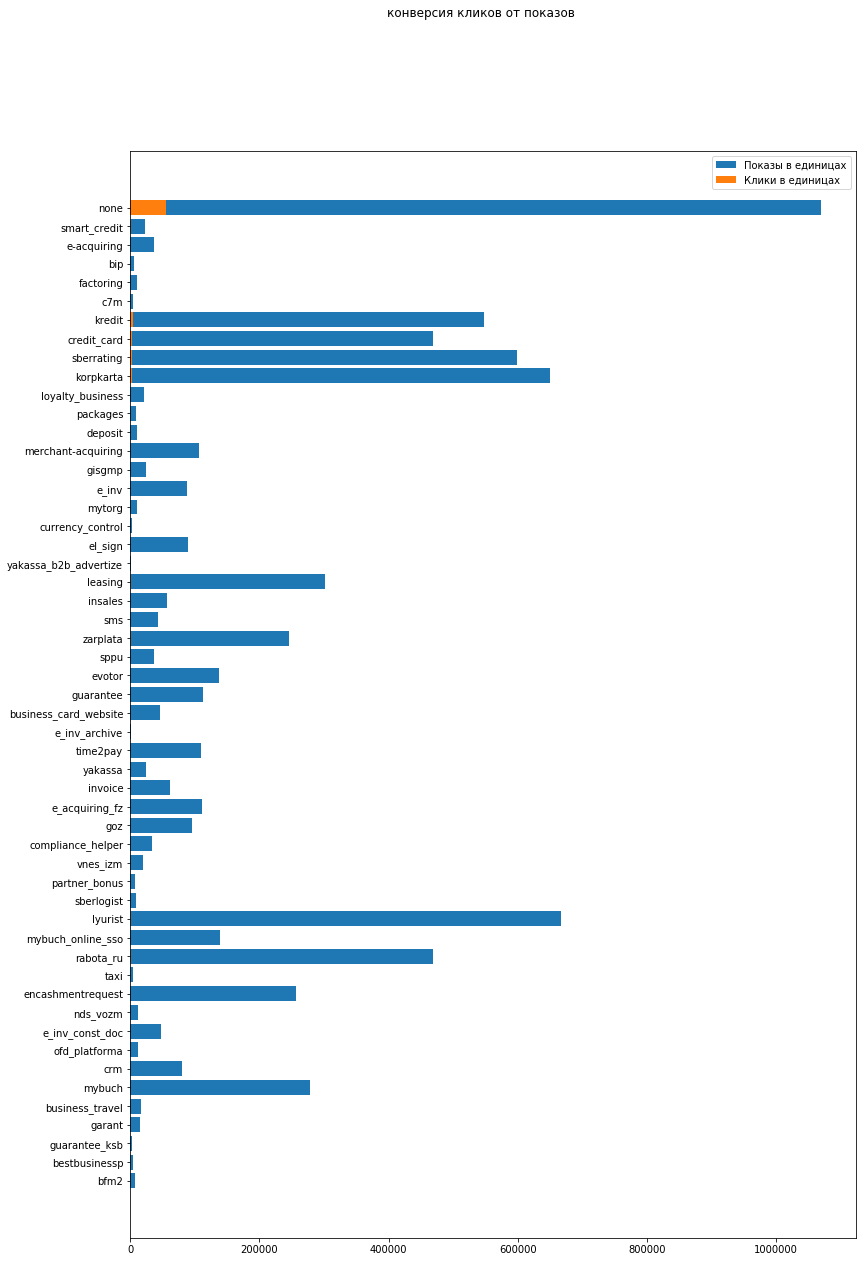

In [43]:
fig, ax = plt.subplots()

bar_show = ax.barh(story_show_stats_pd['product'], story_show_stats_pd['story_show_dist_cnt'], label='Показы в единицах')
bar_click = ax.barh(story_show_stats_pd['product'], story_show_stats_pd['story_click_dist_cnt'], label='Клики в единицах')

fig.suptitle('конверсия кликов от показов')
ax.legend()
ax.invert_yaxis()


fig.set_figwidth(13)
fig.set_figheight(20)
fig.show()

In [45]:
story_show_stats_pd.count()

product                 53
story_show_cnt          53
story_show_dist_cnt     53
story_click_cnt         53
story_click_dist_cnt    53
perc                    53
dtype: int64

# load_users_from_iskra 

In [46]:
ld = load.Loader(init_dsn=True, encoding='cp1251',  sep=',')
db = load.OracleDB('tech_iskra[iskra]', 'Uthvfy123', ld._get_dsn('iskra4')) 
db.connect()

In [48]:
ISKRA_TABLE = "ma_cmdm_ma_customer_sbbol"

In [49]:
query = '''
select * FROM {}
'''.format(ISKRA_TABLE)

In [50]:
sbbol_all_users = pd.read_sql(query, con=db.connection)

In [52]:
sbbol_all_users.head(2)

,CU_ID_SBBOL,SBBOL_NODE,CU_INN,CU_KPP,CU_OGRN,CU_OKPO,CU_ADDR_COMP,CU_NAME_COMP,CU_NAL_STATUS_FLAG,CU_REG_DATE,SUSPENDED,FINANCEBLOCK,PARENT_EKS_ID,CHILD_EKS_ID,LOCKED,ANNULED,REPLICATIONGUID
0,2576451,1,0000000000,000000000,1000000000000,None,"369001, Карачаево-Черкесская Республика, г.Черкесск, ул. Киевская, дом 2, корп. а","Избирательное объединение ""Карачаево-Черкесское региональное отделение Общероссийской политической партии ""Народная партия ""За женщин России""",1.0,2012-07-05 00:00:00,0,0,None,None,0,1,8766f7f1-4eb7-4d3a-a885-df04ee171e9d
1,2584415,1,0000000000,000000000,1000000000000,None,"369001, Карачаево-Черкесская Республика, г.Черкесск, ул. Лермонтова, дом 172","Избирательное объединение ""Карачаево-Черкесское региональное отделение Общероссийской политической партии ""Народ Против Коррупции""",1.0,2013-05-15 00:00:00,0,0,None,None,0,1,cc859b62-5531-40d0-9e43-a5ec1d2191a6


In [53]:
hive.createDataFrame(sbbol_all_users)

Py4JJavaError: An error occurred while calling o387.defaultParallelism.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.GatewayConnection.run(GatewayConnection.java:238)
java.lang.Thread.run(Thread.java:748)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:100)
	at org.apache.spark.SparkContext.defaultParallelism(SparkContext.scala:2359)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
sbbol_all_users_sp = hive.createDataFrame(sbbol_all_users)

###### iskra all_sbbol_users 